# Regression Analysis and Resampling Methods

### Authors:
1. Britt Haanen
2. Pragay Shourya Moudgil

### Preamble:

The following code performs all necessary imports. It also sets up the classes and functions used throughout the code.

In [1]:
# Imports:

#matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#numpy
import numpy as np

#random
from random import random, seed

#tqdm
from tqdm import tqdm

#pandas
import pandas as pd

#imageio
from imageio import imread

#warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Metrics():

    def __init__(self, y_target, y_pred):
        
        self.y_target = y_target
        self.y_pred = y_pred


    def r2_score(self):
        a = self.y_pred - np.mean(self.y_pred)
        b = self.y_target - np.mean(self.y_target)
        return (np.sum(a * b)) ** 2 / (np.sum(a ** 2) * np.sum(b ** 2))

            
    
    def mean_squared_error(self):
        return (np.sum(np.square(self.y_target - self.y_pred ))/len(self.y_target))
    

In [3]:
class DataGenerator():

    def __init__(self, x, y):
        self.x, self.y = x, y


    def FrankeFunction(self):
        #Code source: M Hjorth-Jensen, Project 1, Assignment description, September 2024

        term1 = 0.75*np.exp(-(0.25*(9*self.x-2)**2) - 0.25*((9*self.y-2)**2))
        term2 = 0.75*np.exp(-((9*self.x+1)**2)/49.0 - 0.1*(9*self.y+1))
        term3 = 0.5*np.exp(-(9*self.x-7)**2/4.0 - 0.25*((9*self.y-3)**2))
        term4 = -0.2*np.exp(-(9*self.x-4)**2 - (9*self.y-7)**2)

        self.frankf = term1 + term2 + term3 + term4
        
        return self.frankf
    
    def plot_franke(self, z = None):
        
        if z is None:
            z = self.frankf
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface.
        surf = ax.plot_surface(self.x, self.y, z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

In [4]:
# Utils:
def determine_X(poly_deg, x, y, intercept = False):
    
    #Code below generates the design matrix X for the Franke Function
    #Code based on source: M Hjorth-Jensen. Week 35: From ordinary linear regression to ridge and lasso regression. Lecture notes, August 2024.
    X = np.ones((len(x),int((poly_deg+1)*(poly_deg+2)/2)))
    for i in range(1,poly_deg+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    if intercept is False:
        X = X[:,1:]

    
    return X

def scaling_mean(X_train, X_test):
    mean = np.mean(X_train, axis = 0)
    return X_train - mean, X_test - mean

def prep_train_test(X, z, train_size = 0.66):

    return train_test_split(X, z, train_size=train_size)

def bootstrap(x,
              y,
              z,
              poly_deg,
              model
              ):
    #to do

    pass

def evaluate_stats(y_pred, y_input):
    return [np.mean( np.mean((y_input[:, np.newaxis] - y_pred)**2, axis=1, keepdims=True)),
            np.mean( (y_input - np.mean(y_pred, axis=1, keepdims=True))**2),
            np.mean( np.var(y_pred, axis=1, keepdims=True))
            ] 


In [5]:
class PlotResults():

    def __init__(self):
        pass

    def plot_polynomial(self, 
                    x_axis_val,
                    trainvalues,
                    testvalues = None,
                    title = None,
                    y_label = None,
                    x_label = None,
                    train_label = None,
                    test_label = None,
                    ):
        # Plot data for MSE
        plt.plot(x_axis_val, trainvalues, label=train_label)

        if test_label is not None:
            plt.plot(x_axis_val, testvalues, label=test_label)

        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(np.arange(x_axis_val[0], x_axis_val[-1]+1, step=1))
        plt.legend()
        plt.show()

In [6]:
class OLS():

    def __init__(self, x, y, z, poly_deg, sk_learn = False):
        self.x, self.y, self.z, self.poly_deg, self.sk_learn = np.ravel(x), np.ravel(y), np.ravel(z), poly_deg, sk_learn

    def _beta(self, X, z):
        #calculate beta
        return (np.linalg.inv(X.T @ X) @ X.T ) @ z
    
    def predict(self, X_input):
        return X_input @ self.betahat_train
    
    def fit(self, train_size = 0.66):
        
        X = determine_X(poly_deg=self.poly_deg, x = self.x, y= self.y, intercept = False)

        self.X_train, self.X_test, self.z_train, self.z_test = prep_train_test(X=X, z=self.z, train_size=train_size)

        self.X_train, self.X_test = scaling_mean(self.X_train, self.X_test)
        
        if self.sk_learn is False:
            self.betahat_train = self._beta(X=self.X_train, z=self.z_train)

            return self.betahat_train
        else:
            self.model = linear_model.LinearRegression(fit_intercept=False).fit(self.X_train, self.z_train)
            return self.model
    
    def evaluate(self):

        if self.sk_learn is False:
            ztilde_train = self.predict(self.X_train)
            ztilde_test = self.predict(self.X_test)
        
        else:
            ztilde_train = self.model.predict(self.X_train)
            ztilde_test = self.model.predict(self.X_test)


        return [Metrics(ztilde_train, self.z_train).mean_squared_error(),
                Metrics(ztilde_test, self.z_test).mean_squared_error(),
                Metrics(ztilde_train, self.z_train).r2_score(),
                Metrics(ztilde_test, self.z_test).r2_score()]

     

In [7]:
class RidgeRegression():

    def __init__(self, x, y, z, poly_deg, ld):

        self.x, self.y, self.z, self.poly_deg, self.ld = np.ravel(x), np.ravel(y), np.ravel(z), poly_deg, ld

    def _beta(self, X, z, ld):
        #calculate beta for ridge
        xtxinv_r = np.linalg.inv((X.T.dot(X) + ld*np.identity(X.shape[1])))
        return xtxinv_r.dot(X.T).dot(z)

    def predict(self, X_input):
        return X_input @ self.betahat_train
    

    def fit(self, train_size = 0.66):
            
        X = determine_X(poly_deg=self.poly_deg, x = self.x, y= self.y, intercept = False)

        self.X_train, self.X_test, self.z_train, self.z_test = prep_train_test(X=X, z=self.z, train_size=train_size)

        self.X_train, self.X_test = scaling_mean(self.X_train, self.X_test)
        
        self.betahat_train = self._beta(X=self.X_train, z=self.z_train, ld=self.ld)

        return self.betahat_train
    
    def evaluate(self):

        ztilde_train = self.predict(self.X_train)
        ztilde_test = self.predict(self.X_test)

        return [Metrics(ztilde_train, self.z_train).mean_squared_error(),
                Metrics(ztilde_test, self.z_test).mean_squared_error(),
                Metrics(ztilde_train, self.z_train).r2_score(),
                Metrics(ztilde_test, self.z_test).r2_score()]

In [8]:
class LassoRegression():

    def __init__(self, x, y, z, poly_deg, ld):

        self.x, self.y, self.z, self.poly_deg, self.ld = np.ravel(x), np.ravel(y), np.ravel(z), poly_deg, ld

    def fit(self, train_size = 0.66):
            
        X = determine_X(poly_deg=self.poly_deg, x = self.x, y= self.y, intercept = False)

        
        self.X_train, self.X_test, self.z_train, self.z_test = prep_train_test(X=X, z=self.z, train_size=train_size)

        self.model = linear_model.Lasso(alpha=self.ld, fit_intercept=False)

        self.X_train, self.X_test = scaling_mean(self.X_train, self.X_test)
        
        self.model.fit(self.X_train, self.z_train)

        print(self.model.coef_)

        return self.model.coef_
    
    def evaluate(self):

        ztilde_train = self.model.predict(self.X_train)
        ztilde_test = self.model.predict(self.X_test)

        return [Metrics(ztilde_train, self.z_train).mean_squared_error(),
                Metrics(ztilde_test, self.z_test).mean_squared_error(),
                Metrics(ztilde_train, self.z_train).r2_score(),
                Metrics(ztilde_test, self.z_test).r2_score()]

In [9]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x,y = np.meshgrid(x, y)
z = DataGenerator(x,y).FrankeFunction()

### Part a

Note that our OLS class allows the input sk_learn=False, meaning that the self-written code for OLS based on matrix inversion will be used. This code can be found in the OLS class under the condition "if self.sk_learn is False:". The results given below have been included and commented on in Section 3.1.1 of the report.

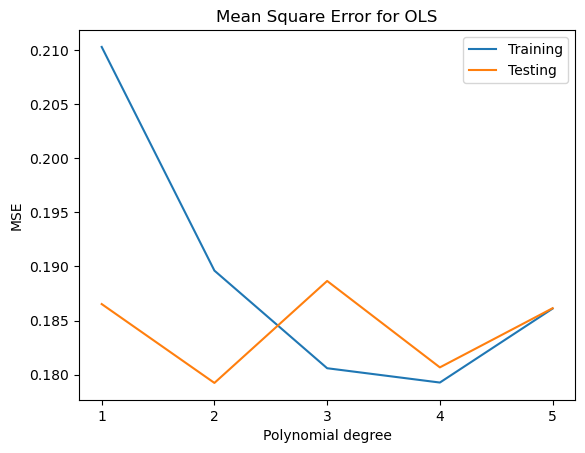

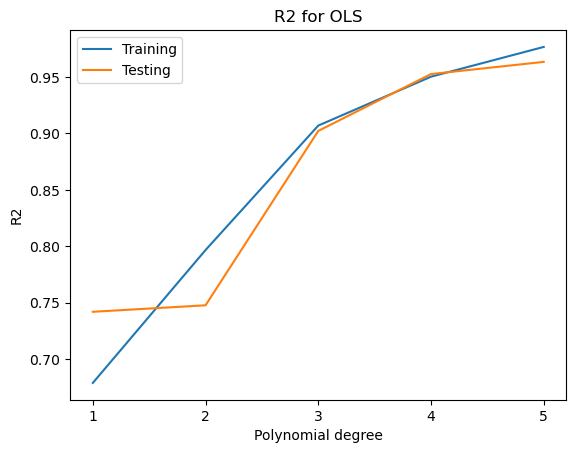

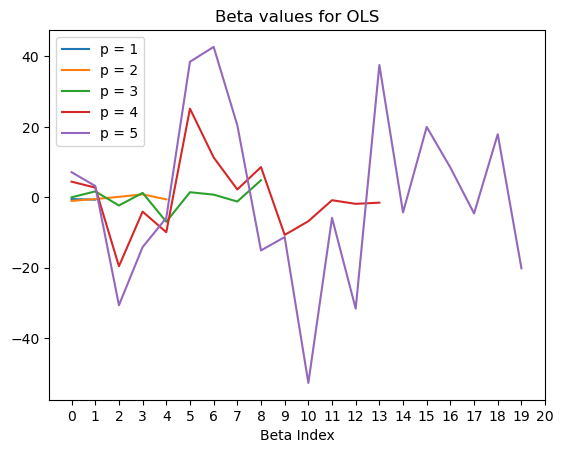

In [10]:
polynomialvalues = np.arange(start=1, stop=6, step=1)
OLS_MSE_trainvalues = np.zeros(len(polynomialvalues))
OLS_MSE_testvalues = np.zeros(len(polynomialvalues))
OLS_R2_trainvalues = np.zeros(len(polynomialvalues))
OLS_R2_testvalues = np.zeros(len(polynomialvalues))
Betavalues = np.zeros([len(polynomialvalues), int((polynomialvalues[-1] + 1) * (polynomialvalues[-1] + 2) / 2)])

# Loop through polynomial degrees and evaluate the model
for i, pvalue in enumerate(polynomialvalues):
    ols_regressor = OLS(x, y, z, poly_deg=pvalue, sk_learn=False)
    Betavalues[i, :int((i + 2) * (i + 3) / 2) - 1] = ols_regressor.fit()
    OLS_MSE_trainvalues[i], OLS_MSE_testvalues[i], OLS_R2_trainvalues[i], \
        OLS_R2_testvalues[i] = ols_regressor.evaluate()

beta_indexes = np.arange(start=0,stop=int((polynomialvalues[-1]+1)*(polynomialvalues[-1]+2)/2),step=1)
Betavalues[Betavalues==0] = np.nan 
PlotResults().plot_polynomial(x_axis_val=polynomialvalues,
                              trainvalues=OLS_MSE_trainvalues,
                              testvalues=OLS_MSE_testvalues,
                              title='Mean Square Error for OLS',
                              y_label= 'MSE',
                              x_label = 'Polynomial degree',
                              train_label='Training',
                              test_label='Testing',)

PlotResults().plot_polynomial(x_axis_val=polynomialvalues,
                              trainvalues=OLS_R2_trainvalues,
                              testvalues=OLS_R2_testvalues,
                              title='R2 for OLS',
                              y_label= 'R2',
                              x_label = 'Polynomial degree',
                              train_label='Training',
                              test_label='Testing')
PlotResults().plot_polynomial(x_axis_val=beta_indexes,
                              trainvalues=Betavalues.T,
                              testvalues=None,
                              title='Beta values for OLS',
                              x_label='Beta Index',
                              train_label=['p = 1',
                                           'p = 2',
                                           'p = 3',
                                           'p = 4',
                                           'p = 5'],
                            )

### Part b

The results given below have been included  and commented on in Section 3.1.2 of the report.

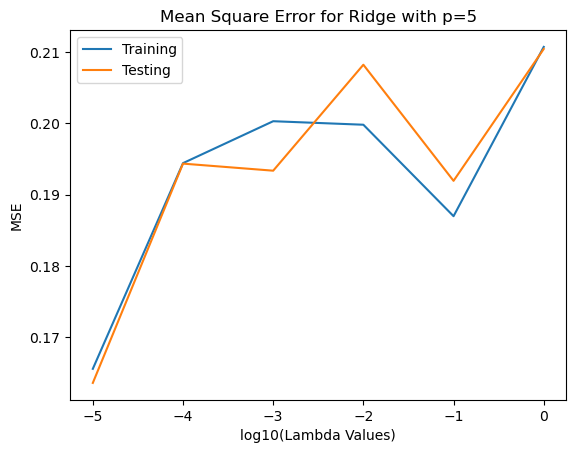

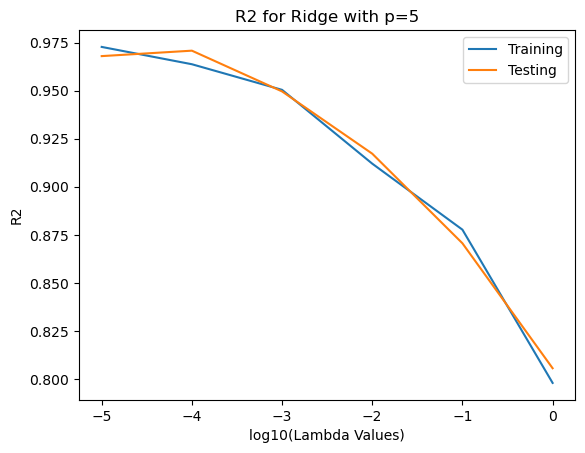

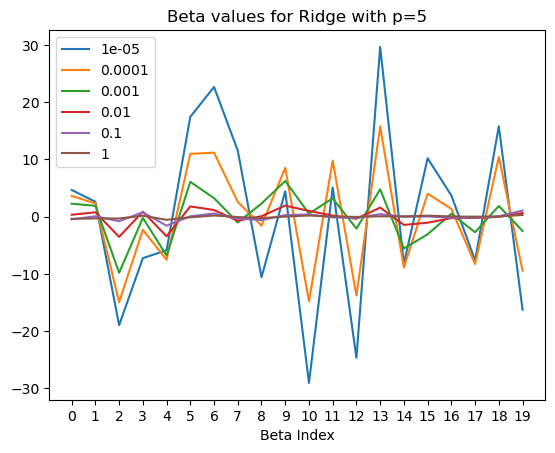

In [11]:
labdavalues = [10**a for a in range(-5, 1)]
polynomialvalues = [5]
ridge_MSE_trainvalues = np.zeros(len(labdavalues))
ridge_MSE_testvalues = np.zeros(len(labdavalues))
ridge_R2_trainvalues = np.zeros(len(labdavalues))
ridge_R2_testvalues = np.zeros(len(labdavalues))
Betavalues = np.zeros([len(labdavalues), int((polynomialvalues[-1] + 1) * (polynomialvalues[-1] + 2) / 2)-1])

# Loop through polynomial degrees and evaluate the model
for i, ld in enumerate(labdavalues):
    ridge_regressor = RidgeRegression(x, y, z, poly_deg=polynomialvalues[-1], ld=ld)
    Betavalues[i] = ridge_regressor.fit()
    ridge_MSE_trainvalues[i], ridge_MSE_testvalues[i], ridge_R2_trainvalues[i], \
        ridge_R2_testvalues[i] = ridge_regressor.evaluate()
    
beta_indexes = np.arange(start=0,stop=int((polynomialvalues[-1]+1)*(polynomialvalues[-1]+2)/2 - 1),step=1)
Betavalues[Betavalues==0] = np.nan 
PlotResults().plot_polynomial(x_axis_val= np.log10(labdavalues),
                              trainvalues=ridge_MSE_trainvalues,
                              testvalues=ridge_MSE_testvalues,
                              title='Mean Square Error for Ridge with p=5',
                              y_label= 'MSE',
                              x_label = 'log10(Lambda Values)',
                              train_label='Training',
                              test_label='Testing')

PlotResults().plot_polynomial(x_axis_val= np.log10(labdavalues),
                              trainvalues=ridge_R2_trainvalues,
                              testvalues=ridge_R2_testvalues,
                              title='R2 for Ridge with p=5',
                              y_label= 'R2',
                              x_label = 'log10(Lambda Values)',
                              train_label='Training',
                              test_label='Testing')
PlotResults().plot_polynomial(x_axis_val=beta_indexes,
                              trainvalues=Betavalues.T,
                              testvalues=None,
                              title='Beta values for Ridge with p=5',
                              x_label='Beta Index',
                              train_label=labdavalues,
                            )


### Part c

The code below executes Lasso Regression using Scikit Learn. The coefficients and plotted results given below have been included and commented on in Section 3.1.3 of the report.

[-0.54214434  0.74923621 -2.27978606  1.97815525 -4.52069902  1.8269796
  0.84080116 -0.76820821  1.3612707   0.85428647 -0.0676018  -0.62871248
 -0.61454329  1.91671214 -1.03630275 -0.36040853  0.43408082  0.06790312
 -0.10217696 -0.06170257]
[-0.11906411  0.90767782 -1.84267743  0.39938325 -3.37233991  0.92197753
  1.11060323 -0.          0.          0.16311808  0.         -0.
 -0.18705294  1.10669943 -0.         -0.1796615  -0.         -0.28313999
 -0.21888741  0.92421581]
[-0.54648517  0.         -0.19152759  0.         -1.22082264 -0.
  0.51388994 -0.         -0.          0.          0.07458269  0.
 -0.          0.          0.          0.          0.          0.
  0.          0.51477955]
[-0.37644491 -0.0539722  -0.         -0.         -0.52011391 -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.        ]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.

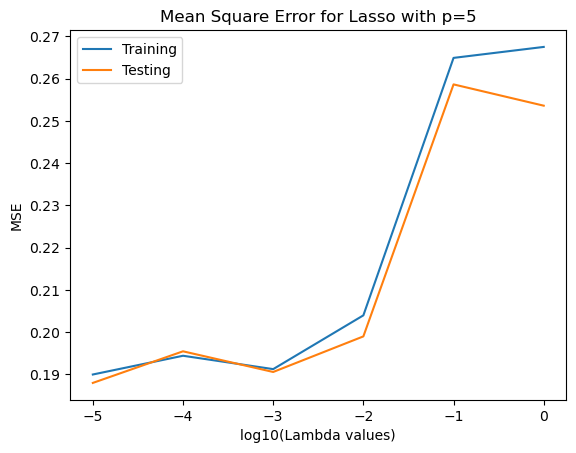

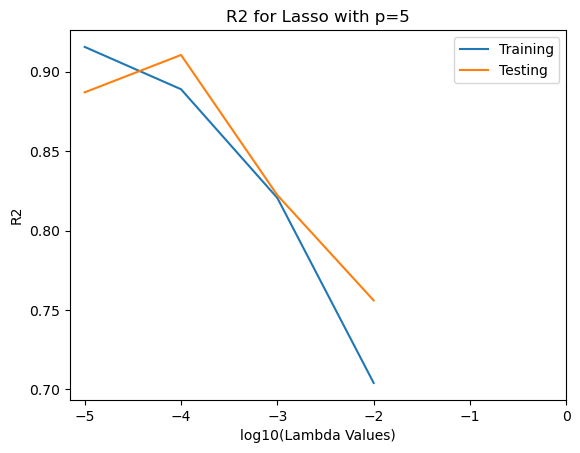

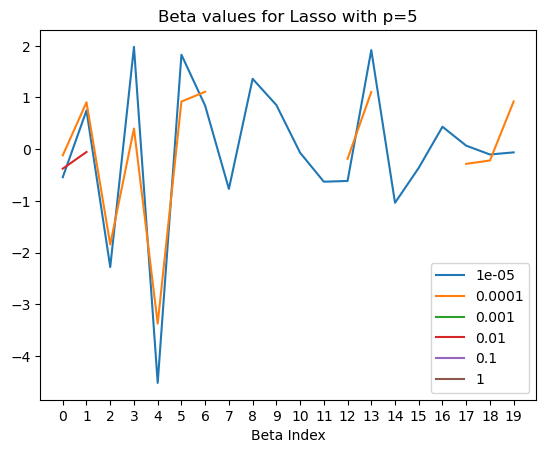

In [12]:
labdavalues = [10**a for a in range(-5, 1)]
polynomialvalues = [5]
lasso_MSE_trainvalues = np.zeros(len(labdavalues))
lasso_MSE_testvalues = np.zeros(len(labdavalues))
lasso_R2_trainvalues = np.zeros(len(labdavalues))
lasso_R2_testvalues = np.zeros(len(labdavalues))


# Loop through polynomial degrees and evaluate the model
for i, ld in enumerate(labdavalues):
    lasso_regressor = LassoRegression(x, y, z, poly_deg=polynomialvalues[-1], ld=ld)
    Betavalues[i] = lasso_regressor.fit()
    lasso_MSE_trainvalues[i], lasso_MSE_testvalues[i], lasso_R2_trainvalues[i], \
        lasso_R2_testvalues[i] = lasso_regressor.evaluate()

beta_indexes = np.arange(start=0,stop=int((polynomialvalues[-1]+1)*(polynomialvalues[-1]+2)/2 - 1),step=1)
Betavalues[Betavalues==0] = np.nan 

PlotResults().plot_polynomial(x_axis_val= np.log10(labdavalues),
                              trainvalues=lasso_MSE_trainvalues,
                              testvalues=lasso_MSE_testvalues,
                              title='Mean Square Error for Lasso with p=5',
                              y_label= 'MSE',
                              x_label = 'log10(Lambda values)',
                              train_label='Training',
                              test_label='Testing')

PlotResults().plot_polynomial(x_axis_val= np.log10(labdavalues),
                              trainvalues=lasso_R2_trainvalues,
                              testvalues=lasso_R2_testvalues,
                              title='R2 for Lasso with p=5',
                              y_label= 'R2',
                              x_label = 'log10(Lambda Values)',
                              train_label='Training',
                              test_label='Testing')
PlotResults().plot_polynomial(x_axis_val=beta_indexes,
                              trainvalues=Betavalues.T,
                              testvalues=None,
                              title='Beta values for Lasso with p=5',
                              x_label='Beta Index',
                              train_label=labdavalues,
                            )


### Part d

This paper-and-pencil exercise has been included in Appendix A of the report. The theoretical section on OLS refers to this appendix.

### Part e

The first snippet of code yields the requested plot like the one given in Hastie et. al.
The paper and pencil part that derives the bias-variance trade-off equations is given in Appendix B of the report. This appendix is referred to and its results are discussed in the theoretical section about Bias-Variance trade-off.
The second snippet of code performs the bias-variance trade-off using bootstrap resampling. The results of this are included and discussed in the results section of the report.  

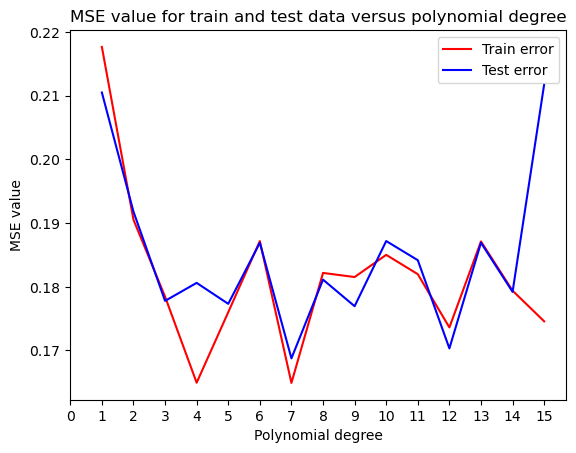

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

def GET_DATA():
    # Make data.
    x = np.arange(0, 1, 0.05)
    y = np.arange(0, 1, 0.05)
    x, y = np.meshgrid(x,y)

    def FrankeFunction(x,y):
        term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
        term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
        term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
        term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
        return term1 + term2 + term3 + term4

    z = FrankeFunction(x, y)
    
    x = x.ravel()
    y = y.ravel()
    z = z.ravel()

    return x, y, z

def Perform_polynomial_Franke_OLS(p,xdata,ydata,zdata):

    def Make_X_Franke(degree, xin, yin):
        X = np.ones((len(xin),int((degree+1)*(degree+2)/2)))
        for i in range(1,degree+1):
            q = int((i)*(i+1)/2)
            for k in range(i+1):
                X[:,q+k] = (xin**(i-k))*(yin**k)
        #Remove intercept
        X = X[:,1:int((degree+1)*(degree+2)/2)]   
        return X     

    DM = Make_X_Franke(p, xdata, ydata)

    #split into training and testing: uses scikit learn train_test_split
    X_train, X_test, z_train, z_test = train_test_split(DM,zdata,train_size=0.66)

    model = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=False))

    ztilde_train = model.fit(X_train,z_train).predict(X_train)
    ztilde_test = model.fit(X_train,z_train).predict(X_test)

    #compute MSE
    def MSE_calc(zinput,zpred):
        diffsq = np.square(zinput - zpred)
        result = (np.sum(diffsq))/len(zinput)
        return result
    
    MSE_train = MSE_calc(z_train,ztilde_train)
    
    MSE_test = MSE_calc(z_test,ztilde_test)


    #compute R2
    def R2_calc(zinput,zpred):
        upperterm = np.sum(np.square(zinput - zpred))
        meanarray = np.zeros((len(zpred),1))
        meanarray[:,0] = np.mean(zinput)
        lowerterm = np.sum(np.square(zinput - meanarray))
        result = 1 - (upperterm/lowerterm)
        return result

    R2_train = R2_calc(z_train,ztilde_train)

    R2_test = R2_calc(z_test,ztilde_test)    



    return [MSE_train, MSE_test, R2_train, R2_test]


[x,y,z] = GET_DATA()

#Initialise arrays for storing data
maxdegree = 15
polynomialvalues = np.arange(start=1,stop=maxdegree+1,step=1)
MSE_trainvalues = np.zeros(maxdegree)
MSE_testvalues = np.zeros(maxdegree)


#perform fit and MSE calculation for each polynomial degree
for pvalue in polynomialvalues:
    [MSEtr, MSEte, R2tr, R2te] = Perform_polynomial_Franke_OLS(pvalue,x,y,z)
    MSE_trainvalues[pvalue-1] = MSEtr
    MSE_testvalues[pvalue-1] = MSEte


#plot data for MSE
plt.plot(polynomialvalues, MSE_trainvalues, 'r-',label="Train error")
plt.plot(polynomialvalues,MSE_testvalues,'b-',label="Test error")
plt.title("MSE value for train and test data versus polynomial degree")
plt.xlabel("Polynomial degree")
plt.xticks(np.arange(0, maxdegree+1, step=1))
plt.ylabel("MSE value")
plt.legend()
plt.show()

100%|█████████████| 14/14 [00:02<00:00,  4.77it/s]


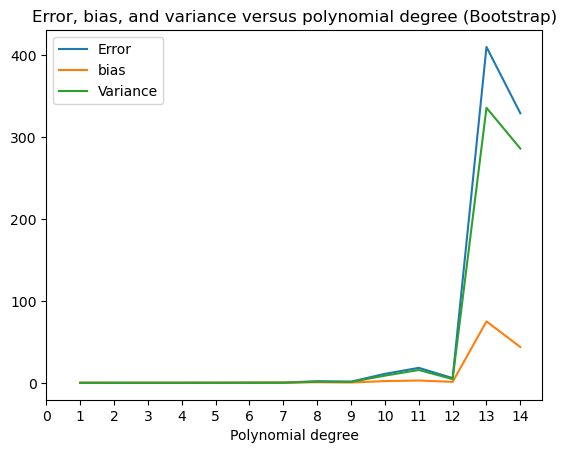

In [13]:
#The code below performs Bootstrap. 
# It was based on code from source: M Hjorth-Jensen. Applied data analysis and machine learning 5: Resampling methods. Lecture notes, August 2024.

n = 40
n_boostraps = 100
maxdegree = 14
polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)


for i, deg in tqdm(enumerate(polynomialvalues), ncols = 50, total=len(polynomialvalues)):
    X = determine_X(poly_deg=deg, x = np.ravel(x), y = np.ravel(y), intercept=False)
    X_train, X_test, z_train, z_test = prep_train_test(X=X, z=np.ravel(z), train_size=0.66)

    X_train, X_test = scaling_mean(X_train, X_test)
    model = linear_model.LinearRegression(fit_intercept=False)

    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for j in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[:, j] = model.fit(X_, z_).predict(X_test)

    error[i] = np.mean( np.mean((z_test[:, np.newaxis] - z_pred)**2, axis=1, keepdims=True) )
    bias[i] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.plot(polynomialvalues, error, label='Error')
plt.plot(polynomialvalues, bias, label='bias')
plt.plot(polynomialvalues, variance, label='Variance')
plt.title("Error, bias, and variance versus polynomial degree (Bootstrap)")
plt.xticks(np.arange(0, maxdegree+1, step=1))
plt.xlabel("Polynomial degree")
plt.legend()
plt.show()

### Part f

The codes below perform the k-fold cross-validation for OLS, Ridge, and Lasso. The results that are plotted here are also included and discussed in the results section of the report. 

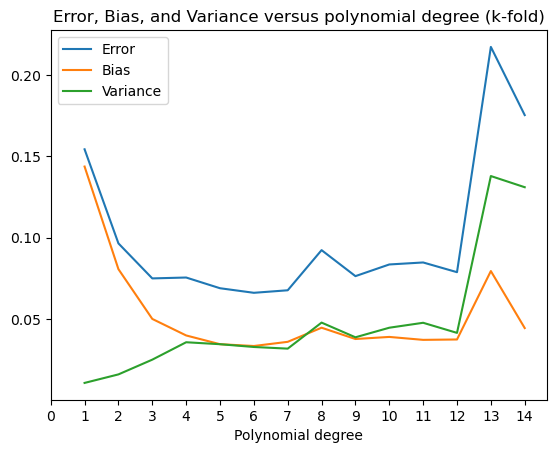

In [14]:
#The code below performs k-fold cross-validation
# It was based on code from source: M Hjorth-Jensen. Applied data analysis and machine learning 5: Resampling methods. Lecture notes, August 2024.

maxdegree = 14
k = 15
polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)

# Initialize a KFold instance
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
Errors_KFold = np.zeros((maxdegree, k))
Biases_KFold = np.zeros((maxdegree, k))
Variances_KFold = np.zeros((maxdegree, k))

z_copy = np.ravel(z)

for i, p in enumerate(polynomialvalues):
    model = linear_model.LinearRegression(fit_intercept=False)
    X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=p)
    for j, (train_inds, test_inds) in enumerate(kfold.split(X)):
        xtrain = X[train_inds]
        ztrain = z_copy[train_inds]

        xtest = X[test_inds]
        ztest = z_copy[test_inds]
        model.fit(xtrain, ztrain[:, np.newaxis])

        zpred = model.predict(xtest)

        Errors_KFold[i,j] = np.mean((ztest-zpred)**2)
        Biases_KFold[i,j] = np.mean((ztest - np.mean(zpred))**2)
        Variances_KFold[i,j] = np.mean((zpred - np.mean(zpred))**2)


Error = np.mean(Errors_KFold, axis = 1)
Bias = np.mean(Biases_KFold, axis = 1)
Variance = np.mean(Variances_KFold, axis = 1)


## Plot
plt.figure()
plt.plot(np.arange(start=1, stop=p+1, step=1), Error, label = 'Error')
plt.plot(np.arange(start=1, stop=p+1, step=1), Bias, label = 'Bias')
plt.plot(np.arange(start=1, stop=p+1, step=1), Variance, label = 'Variance')
plt.xlabel('Polynomial degree')
plt.xticks(np.arange(0, maxdegree+1, step=1))
plt.title("Error, Bias, and Variance versus polynomial degree (k-fold)")
plt.legend()
plt.show()

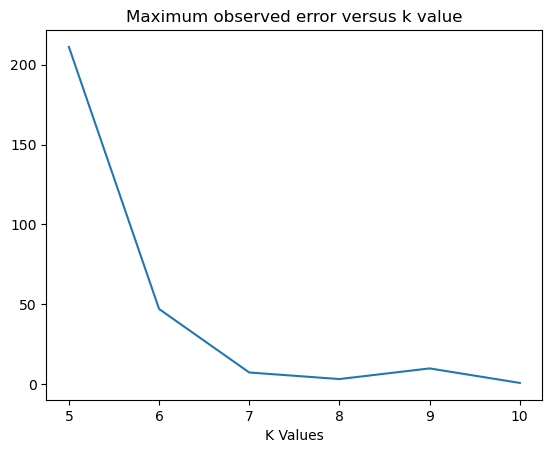

In [36]:
maxdegree = 14

polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)

# Initialize a KFold instance
kvalues = np.arange(start=5, stop=11, step=1)

# Perform the cross-validation to estimate MSE
Errors_KFold = np.zeros((maxdegree, k))
Biases_KFold = np.zeros((maxdegree, k))
Variances_KFold = np.zeros((maxdegree, k))
Errors=np.zeros(len(kvalues))
z_copy = np.ravel(z)

for m, k in enumerate(kvalues):
    kfold = KFold(n_splits = k)
    for i, p in enumerate(polynomialvalues):
        model = linear_model.LinearRegression(fit_intercept=False)
        X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=p)
        for j, (train_inds, test_inds) in enumerate(kfold.split(X)):
            xtrain = X[train_inds]
            ztrain = z_copy[train_inds]

            xtest = X[test_inds]
            ztest = z_copy[test_inds]
            model.fit(xtrain, ztrain[:, np.newaxis])

            zpred = model.predict(xtest)

            Errors_KFold[i,j] = np.mean((ztest-zpred)**2)


    Errors[m] = np.max(np.mean(Errors_KFold, axis = 1))

plt.plot(kvalues, Errors)
plt.title("Maximum observed error versus k value")
plt.xlabel('K Values')
plt.show()


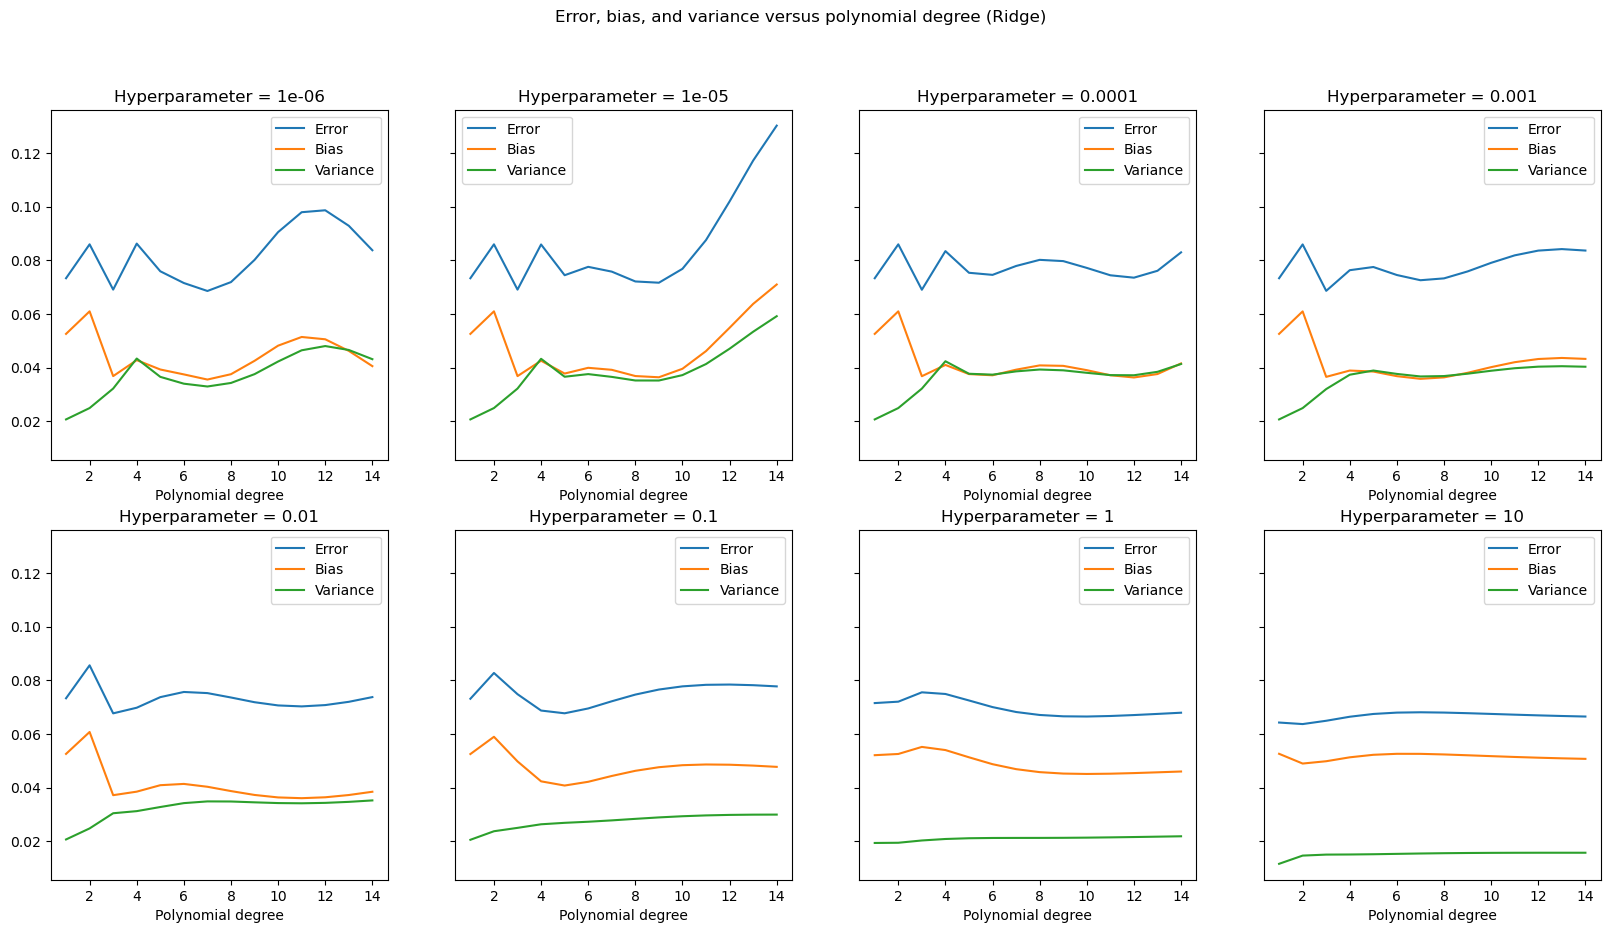

In [53]:
#The code below performs k-fold cross-validation
# It was based on code from source: M Hjorth-Jensen. Applied data analysis and machine learning 5: Resampling methods. Lecture notes, August 2024.

maxdegree = 14

polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)

# Initialize a KFold instance
kvalues = 5

lambdas = [10**x for x in range(-6, 2, 1)]

f = plt.subplots(2, round(len(lambdas)/2), figsize=(20,10),sharey=True)

for m ,lmb in enumerate(lambdas):
    for i, p in enumerate(polynomialvalues):
        model = linear_model.Ridge(alpha=lmb)
        X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=p)
        for j, (train_inds, test_inds) in enumerate(kfold.split(X)):
            xtrain = X[train_inds]
            ztrain = z_copy[train_inds]

            xtest = X[test_inds]
            ztest = z_copy[test_inds]
            model.fit(xtrain, ztrain[:, np.newaxis])

            zpred = model.predict(xtest)

            Errors_KFold[i,j] = np.mean((ztest-zpred)**2)
            Biases_KFold[i,j] = np.mean((ztest - np.mean(zpred))**2)
            Variances_KFold[i,j] = np.mean((zpred - np.mean(zpred))**2)

    Error = np.mean(Errors_KFold, axis = 1)
    Bias = np.mean(Biases_KFold, axis = 1)
    Variance = np.mean(Variances_KFold, axis = 1)
    

    ## Plot
    plt.subplot(2, round(len(lambdas)/2), m+1)
    plt.plot(np.arange(start=1, stop=p+1, step=1), Error, label = 'Error')
    plt.plot(np.arange(start=1, stop=p+1, step=1), Bias, label = 'Bias')
    plt.plot(np.arange(start=1, stop=p+1, step=1), Variance, label = 'Variance')
    plt.xlabel('Polynomial degree')
    plt.title("Hyperparameter = " + str(lmb))
    plt.legend()
    

plt.suptitle("Error, bias, and variance versus polynomial degree (Ridge)")
plt.show()

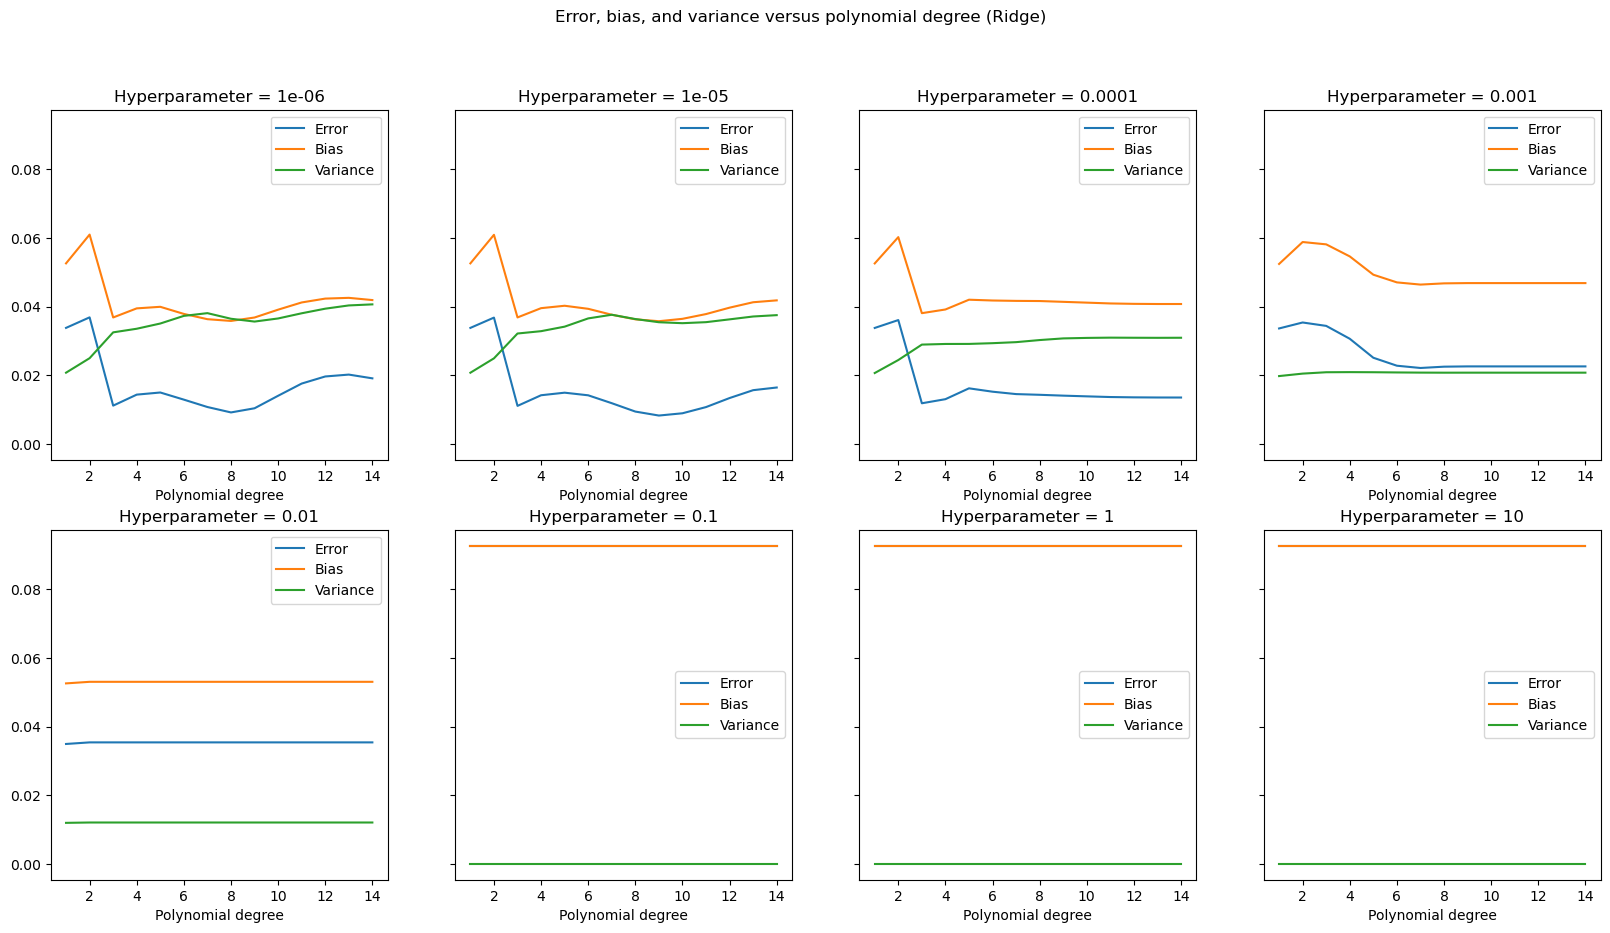

In [54]:
#The code below performs k-fold cross-validation
# It was based on code from source: M Hjorth-Jensen. Applied data analysis and machine learning 5: Resampling methods. Lecture notes, August 2024.

maxdegree = 14

polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)

# Initialize a KFold instance
kvalues = 5

lambdas = [10**x for x in range(-6, 2, 1)]

f = plt.subplots(2, round(len(lambdas)/2), figsize=(20,10),sharey=True)

for m ,lmb in enumerate(lambdas):
    for i, p in enumerate(polynomialvalues):
        model = linear_model.Lasso(alpha=lmb)
        X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=p)
        for j, (train_inds, test_inds) in enumerate(kfold.split(X)):
            xtrain = X[train_inds]
            ztrain = z_copy[train_inds]

            xtest = X[test_inds]
            ztest = z_copy[test_inds]
            model.fit(xtrain, ztrain[:, np.newaxis])

            zpred = model.predict(xtest)

            Errors_KFold[i,j] = np.mean((ztest-zpred)**2)
            Biases_KFold[i,j] = np.mean((ztest - np.mean(zpred))**2)
            Variances_KFold[i,j] = np.mean((zpred - np.mean(zpred))**2)

    Error = np.mean(Errors_KFold, axis = 1)
    Bias = np.mean(Biases_KFold, axis = 1)
    Variance = np.mean(Variances_KFold, axis = 1)
    

    ## Plot
    plt.subplot(2, round(len(lambdas)/2), m+1)
    plt.plot(np.arange(start=1, stop=p+1, step=1), Error, label = 'Error')
    plt.plot(np.arange(start=1, stop=p+1, step=1), Bias, label = 'Bias')
    plt.plot(np.arange(start=1, stop=p+1, step=1), Variance, label = 'Variance')
    plt.xlabel('Polynomial degree')
    plt.title("Hyperparameter = " + str(lmb))
    plt.legend()
    

plt.suptitle("Error, bias, and variance versus polynomial degree (Lasso)")
plt.show()

## Part g

The code below loads the geographical data and applies the three linear regression algorithms. The plots for MSE are included and discussed in the report. The written outputs with MSE and alpha for each polynomial fit are included in the report in tabular form and discussed in the results section. 

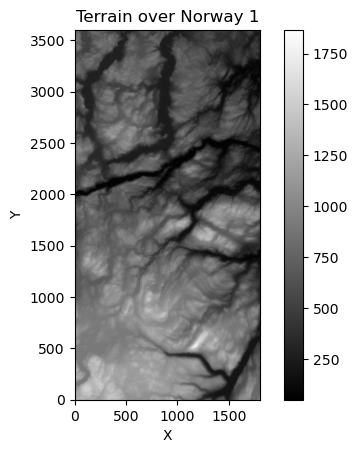

In [55]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray', origin = 'lower')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

x = np.arange(0, terrain1.shape[0], step = 1)
y = np.arange(0, terrain1.shape[1], step = 1)
x, y = np.meshgrid(x, y)
z = terrain1    

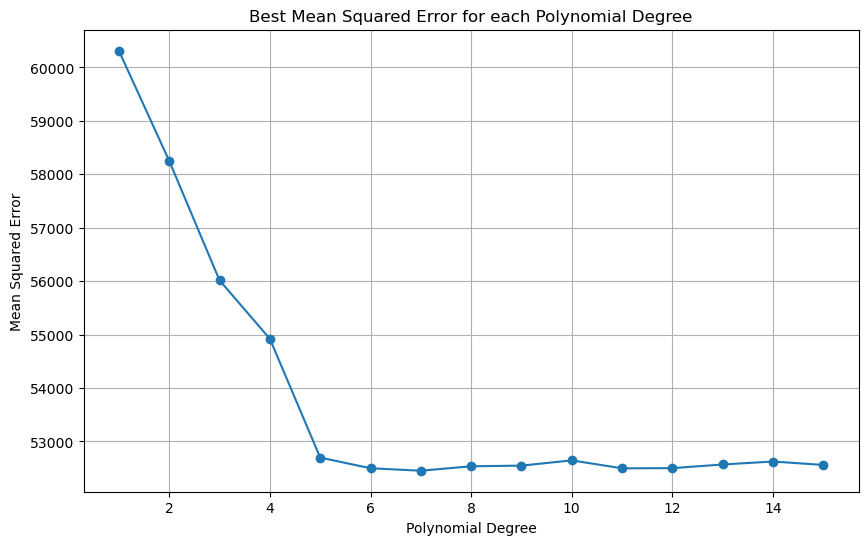

In [59]:
# Assuming determine_X, z, x, and y are defined
z_copy = np.ravel(z)


# Custom scorer to handle polynomial degree
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_squared_error(y, y_pred)

# Initialize the Ridge regression model
linear = linear_model.LinearRegression()

# Initialize the KFold cross-validator
kfold = KFold(n_splits=10)
z_copy = np.ravel(z)
# Perform grid search
best_params = []
for degree in tqdm(polynomialvalues, ncols=50, total=len(polynomialvalues)):
    X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=degree, intercept=False)
    X_train, X_test, z_train, z_test = prep_train_test(X=X, z=z_copy, train_size=0.66)
    X_train, X_test = scaling_mean(X_train, X_test)
    grid_search = GridSearchCV(estimator=linear, param_grid={}, scoring=custom_scorer, cv=kfold, n_jobs=-1)
    grid_search.fit(X_train, z_train)

    best_params.append((degree, grid_search.score(X_test, z_test)))

# Extract the best parameters
best_params_linear = np.array(best_params)
best_degrees_linear = best_params_linear[:, 0]
best_scores_linear = best_params_linear[:, 1]

# Plotting the results

plt.figure(figsize=(10, 6))
plt.plot(best_degrees_linear, best_scores_linear, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Best Mean Squared Error for each Polynomial Degree')
plt.grid(True)
plt.show()

 13%|█▊            | 2/15 [00:22<02:09,  9.96s/it]/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.81284e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.81167e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.81152e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_mod

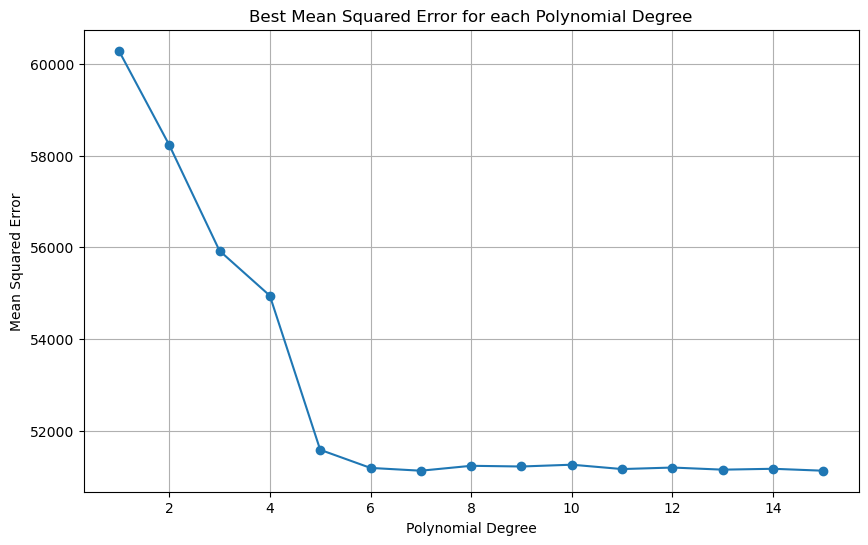

In [68]:
z_copy = np.ravel(z)

# Precompute polynomial features for all degrees
maxdegree = 15
polynomialvalues = np.arange(start=1, stop=maxdegree+1, step=1)
X_poly = [determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=p, intercept=False) for p in polynomialvalues]

# Define the parameter grid
param_grid = {
    'alpha': [10**x for x in range(-6, 2, 1)],
    'degree': polynomialvalues
}

# Custom scorer to handle polynomial degree
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_squared_error(y, y_pred)

# Initialize the Ridge regression model
ridge = linear_model.Ridge()

# Initialize the KFold cross-validator
kfold = KFold(n_splits=10)
z_copy = np.ravel(z)
# Perform grid search
best_params = []
for degree in tqdm(polynomialvalues, ncols=50, total=len(polynomialvalues)):
    X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=degree, intercept=False)
    X_train, X_test, z_train, z_test = prep_train_test(X=X, z=z_copy, train_size=0.66)
    X_train, X_test = scaling_mean(X_train, X_test)
    grid_search = GridSearchCV(estimator=ridge, param_grid={'alpha': param_grid['alpha']}, scoring=custom_scorer, cv=kfold, n_jobs=-1)
    grid_search.fit(X_train, z_train)

    best_params.append((degree, grid_search.best_params_['alpha'], grid_search.score(X_test, z_test)))

# Extract the best parameters
best_params_ridge = np.array(best_params)
best_degrees_ridge = best_params_ridge[:, 0]
best_alphas_ridge = best_params_ridge[:, 1]
best_scores_ridge = best_params_ridge[:, 2]

# Plotting the results

plt.figure(figsize=(10, 6))
plt.plot(best_degrees_ridge, best_scores_ridge, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Best Mean Squared Error for each Polynomial Degree')
plt.grid(True)
plt.show()

  7%|▉             | 1/15 [00:18<04:15, 18.26s/it]/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+10, tolerance: 3.549e+07
  model = cd_fast.enet_coordinate_descent(
/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.809e+09, tolerance: 3.549e+07
  model = cd_fast.enet_coordinate_descent(
/opt/software/custom/software/miniforge3/23.11.0/envs/pygem_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: Converg

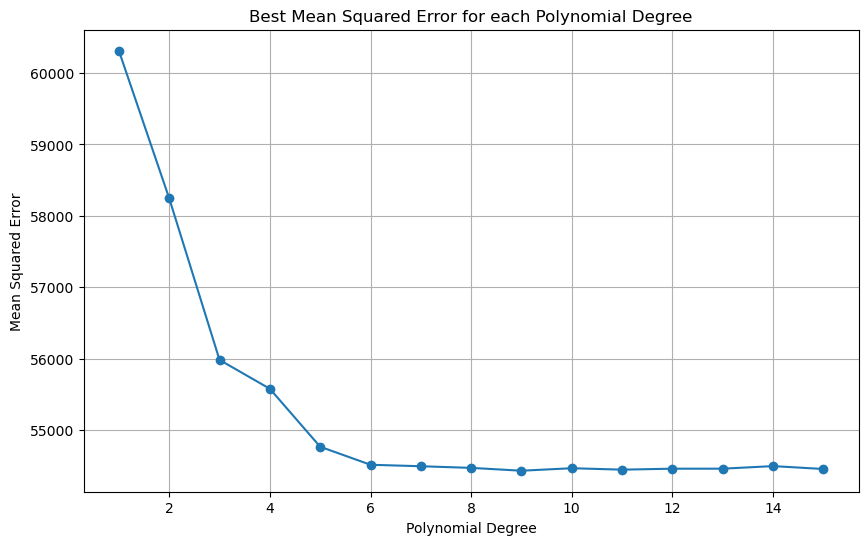

In [66]:
z_copy = np.ravel(z)

# Define the parameter grid
param_grid = {
    'alpha': [10**x for x in range(-6, -5, 1)],
    'degree': polynomialvalues
}

# Custom scorer to handle polynomial degree
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_squared_error(y, y_pred)

# Initialize the Ridge regression model
lasso = linear_model.Lasso()

# Initialize the KFold cross-validator
kfold = KFold(n_splits=10)
z_copy = np.ravel(z)
# Perform grid search
best_params = []
scaler = StandardScaler(with_std=False)
for degree in tqdm(polynomialvalues, ncols=50, total=len(polynomialvalues)):
    X = determine_X(x=np.ravel(x), y=np.ravel(y), poly_deg=degree, intercept=False)
    X_train, X_test, z_train, z_test = prep_train_test(X=X, z=z_copy, train_size=0.66)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    grid_search = GridSearchCV(estimator=lasso, param_grid={'alpha': param_grid['alpha']}, scoring=custom_scorer, cv=kfold, n_jobs=-1)
    grid_search.fit(X_train, z_train)

    best_params.append((degree, grid_search.best_params_['alpha'], grid_search.score(X_test, z_test)))

# Extract the best parameters
best_params_lasso = np.array(best_params)
best_degrees_lasso = best_params_lasso[:, 0]
best_alphas_lasso = best_params_lasso[:, 1]
best_scores_lasso = best_params_lasso[:, 2]

# Plotting the results

plt.figure(figsize=(10, 6))
plt.plot(best_degrees_lasso, best_scores_lasso, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Best Mean Squared Error for each Polynomial Degree')
plt.grid(True)
plt.show()

In [69]:
print('MSE of OLS:', np.min(best_scores_linear))
print('Best polynomial degree for OLS:', best_degrees_linear[np.argmin(best_scores_linear)])

print('MSE of Ridge:', np.min(best_scores_ridge))
print('Best polynomial degree for Ridge:', best_degrees_ridge[np.argmin(best_scores_ridge)])
print('Best alpha for Ridge:', best_alphas_ridge[np.argmin(best_scores_ridge)])

print('MSE of Lasso:', np.min(best_scores_lasso))
print('Best polynomial degree for Lasso:', best_degrees_lasso[np.argmin(best_scores_lasso)])
print('Best alpha for Lasso:', best_alphas_lasso[np.argmin(best_scores_lasso)])

MSE of OLS: 52452.38260567103
Best polynomial degree for OLS: 7.0
MSE of Ridge: 51123.06036111391
Best polynomial degree for Ridge: 15.0
Best alpha for Ridge: 1.0
MSE of Lasso: 54431.74507652091
Best polynomial degree for Lasso: 9.0
Best alpha for Lasso: 1e-06


In [70]:
#Hyper parameters for ridge and lasso:
print('Hyperparameters for Linear:', pd.DataFrame(best_params_linear, columns=['Degree', 'MSE']))
print('Hyperparameters for Ridge:', pd.DataFrame(best_params_ridge, columns=['Degree', 'Alpha', 'MSE']))
print('Hyperparameters for Lasso:', pd.DataFrame(best_params_lasso, columns=['Degree', 'Alpha', 'MSE']))

Hyperparameters for Linear:     Degree           MSE
0      1.0  60313.309000
1      2.0  58252.225881
2      3.0  56015.825996
3      4.0  54922.281360
4      5.0  52698.555368
5      6.0  52498.665994
6      7.0  52452.382606
7      8.0  52535.514946
8      9.0  52547.727371
9     10.0  52645.952691
10    11.0  52497.090587
11    12.0  52500.613502
12    13.0  52569.198123
13    14.0  52624.677456
14    15.0  52560.155915
Hyperparameters for Ridge:     Degree      Alpha           MSE
0      1.0  10.000000  60291.420103
1      2.0   1.000000  58235.066836
2      3.0   0.100000  55924.497938
3      4.0   0.001000  54943.825502
4      5.0   0.000001  51580.084381
5      6.0   0.001000  51184.353706
6      7.0   0.100000  51123.268307
7      8.0   0.010000  51230.401831
8      9.0   0.100000  51215.327966
9     10.0   0.010000  51254.538712
10    11.0   0.000100  51159.312074
11    12.0   0.000001  51192.599476
12    13.0   0.100000  51146.195529
13    14.0   0.010000  51165.535193
14   